In [1]:
import torch
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import math


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 32

img_transform = transform.Compose([transform.ToTensor(), transform.Normalize((0.5,),(0.5,))]) 

train_set = torchvision.datasets.ImageFolder('/home/jaoks/Desktop/proyecto6IA/dataset/train', transform=transform.ToTensor())
val_set = torchvision.datasets.ImageFolder('/home/jaoks/Desktop/proyecto6IA/dataset/val', transform=transform.ToTensor())

print(len(train_set))
print(len(val_set))

cuda:0
1370
340


In [2]:
hd_resol_train = torch.utils.data.Subset(train_set, range(685))
low_resol_train = torch.utils.data.Subset(train_set, range(685, 1370))

hd_resol_val = torch.utils.data.Subset(val_set, range(0, 119))
low_resol_val = torch.utils.data.Subset(val_set, range(170, 289))

hd_resol_test = torch.utils.data.Subset(val_set, range(119, 170))
low_resol_test = torch.utils.data.Subset(val_set, range(289, 340))


In [3]:
train_loader_low = torch.utils.data.DataLoader(dataset=low_resol_train, batch_size=batch_size, shuffle=True)
train_loader_hd = torch.utils.data.DataLoader(dataset=hd_resol_train, batch_size=batch_size, shuffle=True) 

val_loader_low =  torch.utils.data.DataLoader(dataset=low_resol_val, batch_size=batch_size, shuffle=True)
val_loader_hd =  torch.utils.data.DataLoader(dataset=hd_resol_val, batch_size=batch_size, shuffle=True)

test_loader_low =  torch.utils.data.DataLoader(dataset=low_resol_test, batch_size=17, shuffle=True)
test_loader_hd =  torch.utils.data.DataLoader(dataset=hd_resol_test, batch_size=17, shuffle=True)

In [4]:
conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=4, padding=1)
bn1 = nn.BatchNorm2d(32)
conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2, padding=1)
conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2, padding=1)
conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=3, padding=1)
tempimg, _ = train_set[0]
#print(tempimg.shape)
tempimg = tempimg.unsqueeze(0)
print(tempimg.shape)
out_1 = F.relu(bn1(conv1(tempimg)))
print(out_1.shape)
out1 = F.relu(conv2(out_1))
print(out1.shape)
out_3 = F.relu(conv3(out1))
print(out_3.shape)
out_4 = F.relu(conv4(out_3))
print("LAST OUT 4")
print(out_4.shape)
out1 = out_4.view(out1.size(0), -1)
fc = nn.Linear(in_features=256*6*6, out_features=1)
z = fc(out1)
print(z)

fcT = nn.Linear(in_features=1, out_features=256*6*6)
out1 = fcT(z)
#print(out1.shape)
out1 = out1.view(1, 256, 6, 6)
print(out1.shape)


torch.Size([1, 3, 256, 256])
torch.Size([1, 32, 64, 64])
torch.Size([1, 64, 33, 33])
torch.Size([1, 128, 17, 17])
LAST OUT 4
torch.Size([1, 256, 6, 6])
tensor([[0.0217]], grad_fn=<AddmmBackward0>)
torch.Size([1, 256, 6, 6])


In [5]:
convTran1 = nn.ConvTranspose2d(in_channels=256,out_channels=128, kernel_size=2, stride=3, padding=0)
convTran2 = nn.ConvTranspose2d(in_channels=128,out_channels=64, kernel_size=3, stride=2, padding=1)
convTran3 = nn.ConvTranspose2d(in_channels=64,out_channels=32, kernel_size=4, stride=2, padding=2)
convTran4 = nn.ConvTranspose2d(in_channels=64,out_channels=3, kernel_size=4, stride=4, padding=0)
print("SHAPE DECO")
print(out1.shape)

out1 = F.relu(convTran1(out1))
print("OUTPUT CT1")
print(out1.shape)

out1 = F.relu(convTran2(out1))
print("OUTPUT CT2")
print(out1.shape)

out1 = F.relu(convTran3(out1))
print("OUTPUT CT3")
print(out1.shape)

out1 = torch.cat([out1, out_1], 1)
print(out1.shape)
out1 = F.relu(convTran4(out1))
print("OUTPUT CT4")
print(out1.shape)

SHAPE DECO
torch.Size([1, 256, 6, 6])
OUTPUT CT1
torch.Size([1, 128, 17, 17])
OUTPUT CT2
torch.Size([1, 64, 33, 33])
OUTPUT CT3
torch.Size([1, 32, 64, 64])
torch.Size([1, 64, 64, 64])
OUTPUT CT4
torch.Size([1, 3, 256, 256])


In [6]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=4, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2, padding=2)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2, padding=1)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=3, padding=1)
    self.fc = nn.Linear(in_features=256*6*6, out_features=1)

  def forward(self, image):
    out_1 = F.relu(self.bn1(self.conv1(image)))
    out = F.relu(self.conv2(out_1))
    out_3 = F.relu(self.conv3(out))
    out_4 = F.relu(self.conv4(out_3))
    out = out_4.view(out_4.size(0), -1)
    z = self.fc(out)
    return z, out_1, out_3, out_4

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.fc    = nn.Linear(in_features=1,out_features=256*6*6)
    self.convTran1 = nn.ConvTranspose2d(in_channels=256,out_channels=128, kernel_size=2, stride=3, padding=0)
    self.convTran2 = nn.ConvTranspose2d(in_channels=128,out_channels=64, kernel_size=3, stride=2, padding=1)
    self.convTran3 = nn.ConvTranspose2d(in_channels=64,out_channels=32, kernel_size=4, stride=2, padding=2)
    self.convTran4 = nn.ConvTranspose2d(in_channels=64,out_channels=3, kernel_size=4, stride=4, padding=0)
    
  def forward(self, latent, out_1, out_3, out_4):
    out = self.fc(latent)
    out = out.view(out.size(0), 256, 6, 6)
    #out = torch.cat([out, out_4], 1)
    out = F.relu(self.convTran1(out))
    #out = torch.cat([out, out_3], 1)
    out = F.relu(self.convTran2(out))
    out = F.relu(self.convTran3(out))
    #print(out.shape)
    #print(out_1.shape)
    out = torch.cat([out, out_1], 1)
    #print(out.shape)
    out = F.relu(self.convTran4(out))
    return out

In [7]:
class Autoencoder(nn.Module):
   def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

   def forward(self, x):
        latent, out_1, out_3, out_4 = self.encoder(x)
        x_recon = self.decoder(latent, out_1, out_3, out_4)
        return  x_recon

In [8]:
def train(model, train_loader, train_loader_hd, val_loader, val_loader_hd, Epochs, loss_fn):
    train_loss_avg = []
    val_loss_avg = []
    for epoch in range(Epochs):
        train_loss_avg.append(0)
        num_batches = 0
        iterator = iter(train_loader_hd)
        for image_batch, _ in train_loader:
            image_batch = image_batch.to(device)
            batch_list = next(iterator)
            image_batch_hd = batch_list[0].to(device)
            image_batch_recon = model(image_batch)
            loss = loss_fn(image_batch_recon, image_batch_hd)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
          
            train_loss_avg[-1] += loss.item()
            num_batches += 1
        
        train_loss_avg[-1] /= num_batches
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, Epochs, train_loss_avg[-1]))
        
        iterator = iter(val_loader_hd)
        val_loss_avg.append(0)
        num_batches=0
        for image_batch, _ in val_loader:
            image_batch = image_batch.to(device)
            batch_list = next(iterator)
            image_batch_hd = batch_list[0].to(device)
            image_batch_recon = model(image_batch)
            with torch.no_grad():
                loss = loss_fn(image_batch_recon, image_batch_hd)
                val_loss_avg[-1] += loss.item()
                num_batches += 1
        val_loss_avg[-1] /= num_batches
        print('Epoch [%d / %d] average reconstruction validation error: %f' % (epoch+1, Epochs, val_loss_avg[-1]))
                
    return train_loss_avg, val_loss_avg

In [9]:
capacity = 64
epochs = 50    
learning_rate = 0.001
autoencoder = Autoencoder()
autoencoder.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-6)


loss_result, loss_val = train(autoencoder,train_loader_low, train_loader_hd, val_loader_low, val_loader_hd, epochs, loss_fn)

Epoch [1 / 50] average reconstruction error: 0.182596
Epoch [1 / 50] average reconstruction validation error: 0.141779
Epoch [2 / 50] average reconstruction error: 0.116827
Epoch [2 / 50] average reconstruction validation error: 0.095776
Epoch [3 / 50] average reconstruction error: 0.092557
Epoch [3 / 50] average reconstruction validation error: 0.086645
Epoch [4 / 50] average reconstruction error: 0.087176
Epoch [4 / 50] average reconstruction validation error: 0.085360
Epoch [5 / 50] average reconstruction error: 0.085878
Epoch [5 / 50] average reconstruction validation error: 0.086084
Epoch [6 / 50] average reconstruction error: 0.084721
Epoch [6 / 50] average reconstruction validation error: 0.083196
Epoch [7 / 50] average reconstruction error: 0.085467
Epoch [7 / 50] average reconstruction validation error: 0.082402
Epoch [8 / 50] average reconstruction error: 0.083003
Epoch [8 / 50] average reconstruction validation error: 0.082901
Epoch [9 / 50] average reconstruction error: 0.0

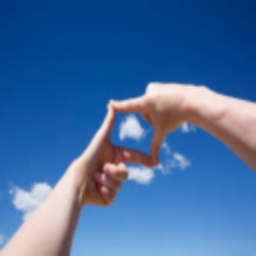

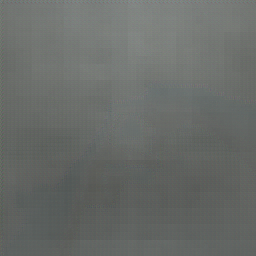

In [13]:
for image_batch, _ in train_loader_low:
  image_batch = image_batch.to(device)
  image_batch_recon = autoencoder(image_batch)
  #Show_imgs(image_batch[0].cpu(),"")
  #Show_imgs(image_batch_recon[0].cpu(),"")
  #image_batch[0].cpu() 
  im = transform.ToPILImage()(image_batch[0]).convert("RGB")  
  display(im)
  imt = transform.ToPILImage()(image_batch_recon[0]).convert("RGB")
  display(imt) 
  break